# Swing Option Pricing: Quantitative Analysis
## D4PG vs. Longstaff-Schwartz Benchmark Comparison

**Analysis Target**: Energy market swing option with HHK underlying process  
**Methodology**: Distributional Deep Deterministic Policy Gradient (D4PG) vs. LSM benchmark  
**Contract Structure**: Multi-exercise derivative with volume constraints

In [1]:
EXPERIMENT = 'MonthlySwing_d'  # Analysis target experiment

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, json
from scipy import stats
from pathlib import Path
plt.style.use('seaborn-v0_8'); sns.set_palette("husl")

# Load experimental data
base_path = Path(f'../logs/{EXPERIMENT}')
params = json.load(open(base_path / f'{EXPERIMENT}_parameters.json'))
eval_df = pd.read_csv(base_path / f'{EXPERIMENT}_evaluation.csv')
train_df = pd.read_csv(base_path / f'{EXPERIMENT}_training.csv')
raw_df = pd.read_csv(base_path / f'{EXPERIMENT}_raw_episodes.csv')

print(f"Contract Parameters:\nStrike: ${params['strike']:.0f} | Maturity: {params['maturity']:.3f}y | Rights: {params['n_rights']} | Max Volume: {params['Q_max']}")
print(f"HHK Model: α={params['alpha']}, σ={params['sigma']}, β={params['beta']}, λ={params['lam']}, μ_J={params['mu_J']}")

Contract Parameters:
Strike: $100 | Maturity: 0.083y | Rights: 22 | Max Volume: 20.0
HHK Model: α=12.0, σ=1.2, β=150.0, λ=6.0, μ_J=0.3


## 1. Pricing Performance: LSM vs. D4PG

In [2]:
# Extract key pricing metrics
lsm_price = eval_df[eval_df['eval_run'] == 'LSM_Benchmark']['option_price'].iloc[0]
d4pg_price = eval_df[eval_df['eval_run'] != 'LSM_Benchmark']['option_price'].iloc[0]
d4pg_std = eval_df[eval_df['eval_run'] != 'LSM_Benchmark']['price_std'].iloc[0]

# Statistical significance test
price_diff = d4pg_price - lsm_price
rel_diff = price_diff / lsm_price * 100
sharpe_improvement = price_diff / d4pg_std if d4pg_std > 0 else np.inf

print(f"LSM Benchmark Price: ${lsm_price:.2f}")
print(f"D4PG Price: ${d4pg_price:.2f} (σ=${d4pg_std:.2f})")
print(f"Pricing Gap: ${price_diff:.2f} ({rel_diff:+.1f}%) | Sharpe Ratio: {sharpe_improvement:.2f}")
print(f"Statistical Significance: {abs(price_diff/d4pg_std):.1f}σ {'✓' if abs(price_diff/d4pg_std) > 2 else '✗'}")

LSM Benchmark Price: $441.50
D4PG Price: $579.55 (σ=$541.76)
Pricing Gap: $138.04 (+31.3%) | Sharpe Ratio: 0.25
Statistical Significance: 0.3σ ✗


## 2. Exercise Strategy Analysis

In [3]:
# Exercise behavior comparison
lsm_exercises = eval_df[eval_df['eval_run'] == 'LSM_Benchmark']['avg_exercise_count'].iloc[0]
d4pg_exercises = eval_df[eval_df['eval_run'] != 'LSM_Benchmark']['avg_exercise_count'].iloc[0]
lsm_volume = eval_df[eval_df['eval_run'] == 'LSM_Benchmark']['avg_total_exercised'].iloc[0]
d4pg_volume = eval_df[eval_df['eval_run'] != 'LSM_Benchmark']['avg_total_exercised'].iloc[0]

print(f"Exercise Frequency - LSM: {lsm_exercises:.1f} | D4PG: {d4pg_exercises:.1f} ({(d4pg_exercises-lsm_exercises)/lsm_exercises*100:+.1f}%)")
print(f"Volume Utilization - LSM: {lsm_volume:.2f}/{params['Q_max']} ({lsm_volume/params['Q_max']*100:.1f}%) | D4PG: {d4pg_volume:.2f}/{params['Q_max']} ({d4pg_volume/params['Q_max']*100:.1f}%)")

# Exercise efficiency metrics
lsm_efficiency = lsm_price / lsm_exercises
d4pg_efficiency = d4pg_price / d4pg_exercises if d4pg_exercises > 0 else 0
print(f"Price per Exercise - LSM: ${lsm_efficiency:.2f} | D4PG: ${d4pg_efficiency:.2f} ({(d4pg_efficiency-lsm_efficiency)/lsm_efficiency*100:+.1f}%)")

Exercise Frequency - LSM: 16.1 | D4PG: 12.3 (-23.9%)
Volume Utilization - LSM: 16.13/20.0 (80.7%) | D4PG: 18.79/20.0 (94.0%)
Price per Exercise - LSM: $27.36 | D4PG: $47.19 (+72.5%)


## 3. Training Convergence & Learning Dynamics

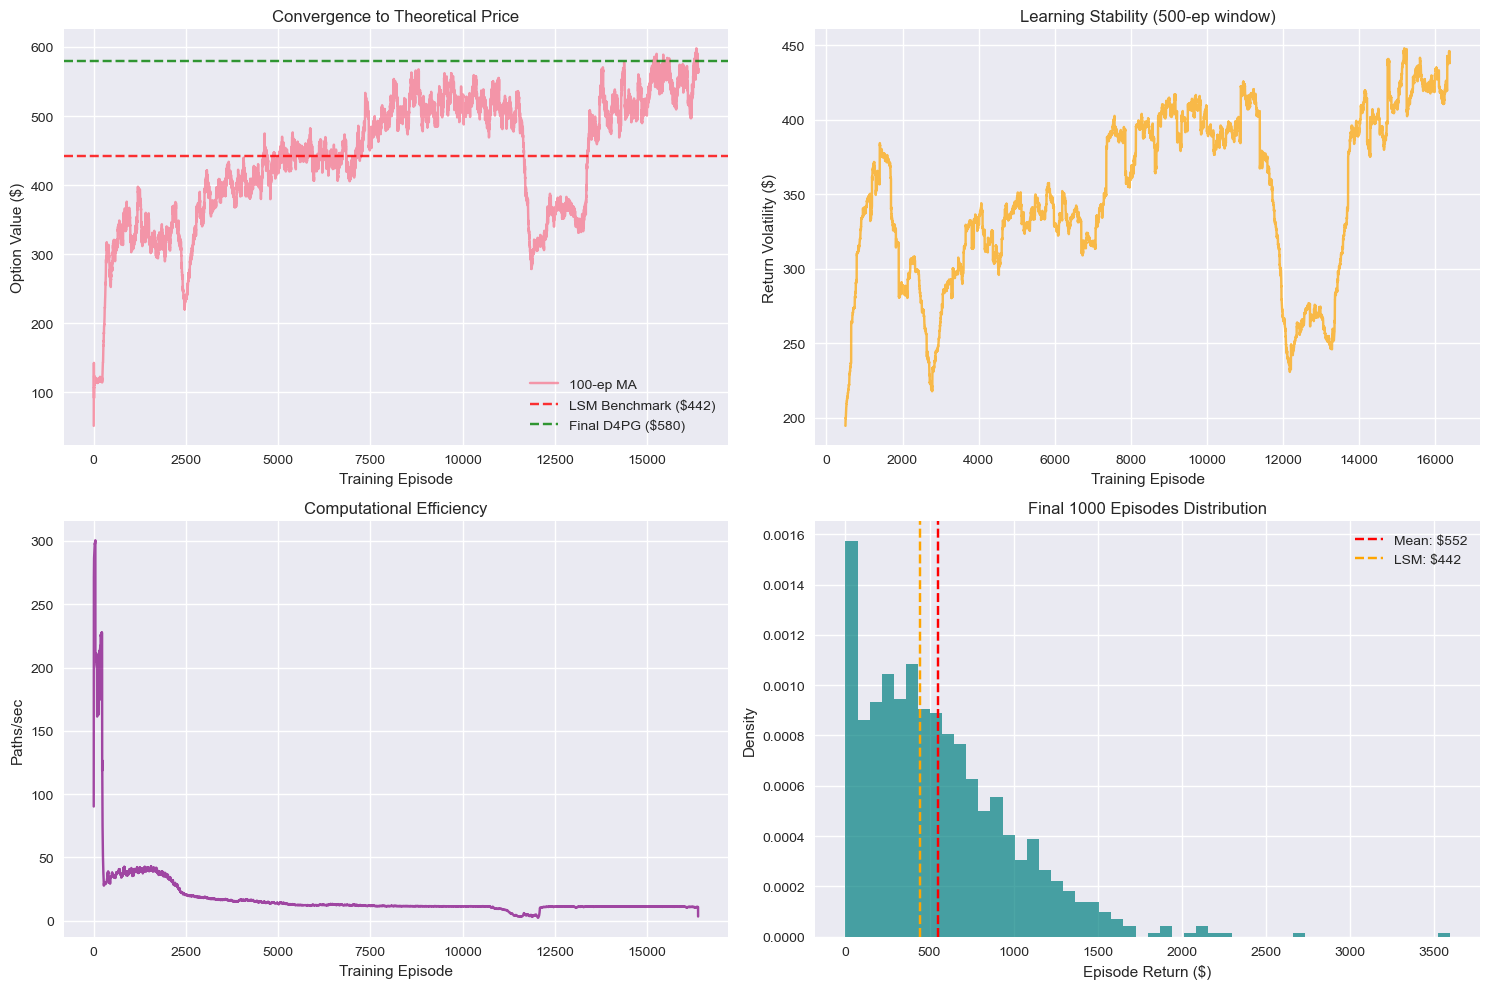

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Return evolution with benchmark
ax1.plot(train_df['episode'], train_df['avg_100'], alpha=0.7, label='100-ep MA')
ax1.axhline(lsm_price, color='red', linestyle='--', alpha=0.8, label=f'LSM Benchmark (${lsm_price:.0f})')
ax1.axhline(d4pg_price, color='green', linestyle='--', alpha=0.8, label=f'Final D4PG (${d4pg_price:.0f})')
ax1.set_ylabel('Option Value ($)'); ax1.set_xlabel('Training Episode'); ax1.legend(); ax1.set_title('Convergence to Theoretical Price')

# Volatility analysis
window = 500; train_df['volatility'] = train_df['return'].rolling(window).std()
ax2.plot(train_df['episode'], train_df['volatility'], color='orange', alpha=0.7)
ax2.set_ylabel('Return Volatility ($)'); ax2.set_xlabel('Training Episode'); ax2.set_title(f'Learning Stability ({window}-ep window)')

# Learning efficiency
ax3.plot(train_df['episode'], train_df['paths_per_sec'], alpha=0.7, color='purple')
ax3.set_ylabel('Paths/sec'); ax3.set_xlabel('Training Episode'); ax3.set_title('Computational Efficiency')

# Distribution analysis
recent_returns = train_df['return'].tail(1000)
ax4.hist(recent_returns, bins=50, alpha=0.7, density=True, color='teal')
ax4.axvline(recent_returns.mean(), color='red', linestyle='--', label=f'Mean: ${recent_returns.mean():.0f}')
ax4.axvline(lsm_price, color='orange', linestyle='--', label=f'LSM: ${lsm_price:.0f}')
ax4.set_xlabel('Episode Return ($)'); ax4.set_ylabel('Density'); ax4.legend(); ax4.set_title('Final 1000 Episodes Distribution')

plt.tight_layout(); plt.show()

## 4. Path-Level Exercise Analysis

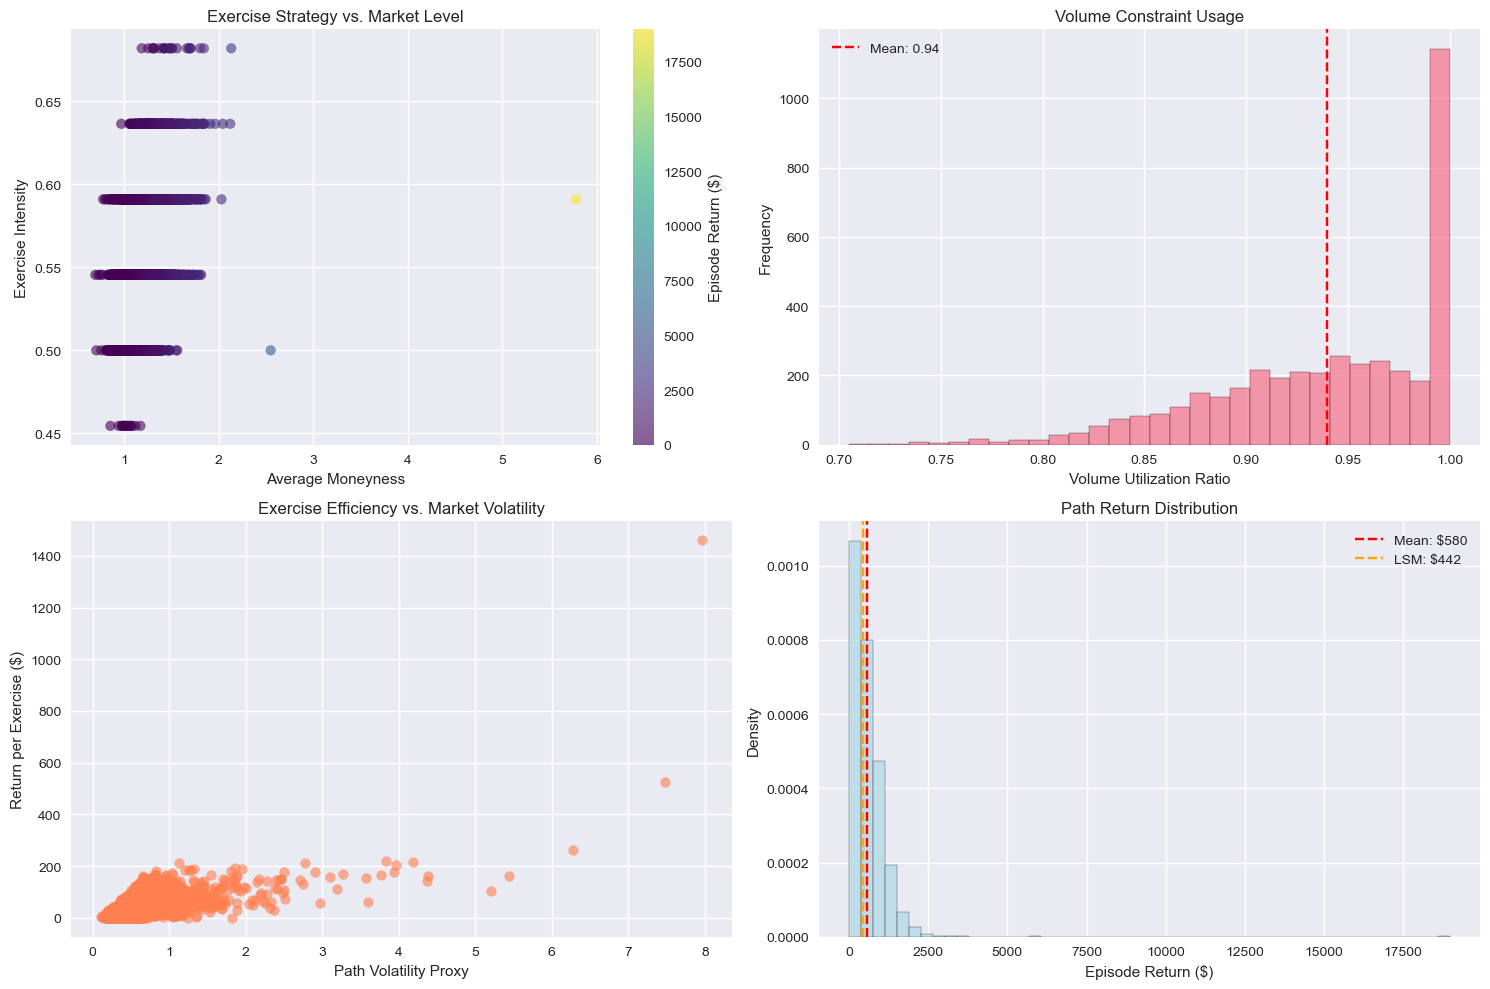

In [5]:
# Exercise pattern analysis by market conditions
raw_df['exercise_intensity'] = raw_df['exercise_count'] / params['n_rights']
raw_df['volume_utilization'] = raw_df['total_exercised'] / params['Q_max']
raw_df['moneyness'] = raw_df['avg_spot_price'] / params['strike']
raw_df['volatility_proxy'] = (raw_df['max_spot_price'] - raw_df['min_spot_price']) / raw_df['avg_spot_price']
raw_df['return_per_exercise'] = raw_df['return'] / raw_df['exercise_count'].replace(0, np.nan)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Exercise vs. Moneyness
scatter = ax1.scatter(raw_df['moneyness'], raw_df['exercise_intensity'], c=raw_df['return'], alpha=0.6, cmap='viridis')
ax1.set_xlabel('Average Moneyness'); ax1.set_ylabel('Exercise Intensity'); ax1.set_title('Exercise Strategy vs. Market Level')
plt.colorbar(scatter, ax=ax1, label='Episode Return ($)')

# Volume utilization distribution
ax2.hist(raw_df['volume_utilization'], bins=30, alpha=0.7, edgecolor='black')
ax2.axvline(raw_df['volume_utilization'].mean(), color='red', linestyle='--', label=f'Mean: {raw_df["volume_utilization"].mean():.2f}')
ax2.set_xlabel('Volume Utilization Ratio'); ax2.set_ylabel('Frequency'); ax2.legend(); ax2.set_title('Volume Constraint Usage')

# Exercise efficiency by market volatility
ax3.scatter(raw_df['volatility_proxy'], raw_df['return_per_exercise'], alpha=0.6, color='coral')
ax3.set_xlabel('Path Volatility Proxy'); ax3.set_ylabel('Return per Exercise ($)'); ax3.set_title('Exercise Efficiency vs. Market Volatility')

# Return distribution analysis
ax4.hist(raw_df['return'], bins=50, alpha=0.7, density=True, color='lightblue', edgecolor='black')
ax4.axvline(raw_df['return'].mean(), color='red', linestyle='--', label=f'Mean: ${raw_df["return"].mean():.0f}')
ax4.axvline(lsm_price, color='orange', linestyle='--', label=f'LSM: ${lsm_price:.0f}')
ax4.set_xlabel('Episode Return ($)'); ax4.set_ylabel('Density'); ax4.legend(); ax4.set_title('Path Return Distribution')

plt.tight_layout(); plt.show()

## 5. Risk Metrics & Tail Analysis

In [6]:
# Risk analytics
returns = raw_df['return']
var_95 = np.percentile(returns, 5); var_99 = np.percentile(returns, 1)
cvar_95 = returns[returns <= var_95].mean(); cvar_99 = returns[returns <= var_99].mean()
skewness = stats.skew(returns); kurtosis = stats.kurtosis(returns)
sharpe = returns.mean() / returns.std() if returns.std() > 0 else 0

print(f"Risk Metrics (N={len(returns)} paths):")
print(f"VaR(95%): ${var_95:.2f} | CVaR(95%): ${cvar_95:.2f}")
print(f"VaR(99%): ${var_99:.2f} | CVaR(99%): ${cvar_99:.2f}")
print(f"Skewness: {skewness:.3f} | Excess Kurtosis: {kurtosis:.3f}")
print(f"Sharpe Ratio: {sharpe:.3f} | Max Drawdown: ${returns.min():.2f}")

# Tail correlation analysis
tail_threshold = np.percentile(returns, 10)
tail_data = raw_df[raw_df['return'] <= tail_threshold]
if len(tail_data) > 10:
    corr_matrix = tail_data[['return', 'moneyness', 'volatility_proxy', 'exercise_intensity']].corr()
    print(f"\nTail Risk Correlations (bottom 10% returns):")
    print(f"Return vs Moneyness: {corr_matrix.loc['return', 'moneyness']:.3f}")
    print(f"Return vs Volatility: {corr_matrix.loc['return', 'volatility_proxy']:.3f}")
    print(f"Return vs Exercise Intensity: {corr_matrix.loc['return', 'exercise_intensity']:.3f}")

Risk Metrics (N=4096 paths):
VaR(95%): $20.42 | CVaR(95%): $5.51
VaR(99%): $0.00 | CVaR(99%): $0.00
Skewness: 10.445 | Excess Kurtosis: 326.338
Sharpe Ratio: 1.070 | Max Drawdown: $0.00

Tail Risk Correlations (bottom 10% returns):
Return vs Moneyness: 0.650
Return vs Volatility: -0.021
Return vs Exercise Intensity: 0.116


## 6. Model Performance Diagnostics

In [7]:
# Statistical tests and model validation
print(f"Model Validation Tests:")

# Normality test
shapiro_stat, shapiro_p = stats.shapiro(returns.sample(min(5000, len(returns)), random_state=42))
print(f"Normality (Shapiro-Wilk): W={shapiro_stat:.4f}, p={shapiro_p:.2e} {'✗' if shapiro_p < 0.05 else '✓'}")

# Convergence test (last 25% vs. benchmark)
final_quarter = train_df['return'].tail(len(train_df)//4)
t_stat, t_p = stats.ttest_1samp(final_quarter, lsm_price)
print(f"Convergence Test (t-test vs. LSM): t={t_stat:.3f}, p={t_p:.3f} {'✓' if t_p > 0.05 else '✗'}")

# Exercise constraint validation
max_exercises = raw_df['exercise_count'].max()
max_volume = raw_df['total_exercised'].max()
constraint_violations = sum((raw_df['exercise_count'] > params['n_rights']) | (raw_df['total_exercised'] > params['Q_max']))
print(f"Constraint Adherence: Max Exercises={max_exercises}/{params['n_rights']}, Max Volume={max_volume:.2f}/{params['Q_max']}, Violations={constraint_violations}")

# Training efficiency metrics
final_performance = train_df['avg_100'].iloc[-1]
convergence_episode = train_df[train_df['avg_100'] >= lsm_price * 0.95].index[0] + 1 if any(train_df['avg_100'] >= lsm_price * 0.95) else len(train_df)
print(f"\nTraining Efficiency:")
print(f"Final Performance: ${final_performance:.2f} ({(final_performance/lsm_price-1)*100:+.1f}% vs. LSM)")
print(f"Convergence Speed: {convergence_episode}/{len(train_df)} episodes ({convergence_episode/len(train_df)*100:.1f}%)")
print(f"Computational Cost: {train_df['time_elapsed'].iloc[-1]:.1f}s total, {train_df['paths_per_sec'].mean():.0f} paths/sec avg")

Model Validation Tests:
Normality (Shapiro-Wilk): W=0.6972, p=2.43e-65 ✗
Convergence Test (t-test vs. LSM): t=7.479, p=0.000 ✗
Constraint Adherence: Max Exercises=15/22, Max Volume=20.00/20.0, Violations=0

Training Efficiency:
Final Performance: $569.15 (+28.9% vs. LSM)
Convergence Speed: 3065/16384 episodes (18.7%)
Computational Cost: 1365.1s total, 18 paths/sec avg


## 7. Economic Interpretation & Greeks

In [8]:
# Economic analysis
intrinsic_value = max(0, params['S0'] - params['strike']) * params['Q_max']
time_value = d4pg_price - intrinsic_value
option_premium = d4pg_price / (params['S0'] * params['Q_max']) * 100  # Premium as % of underlying

# Approximate Greeks via finite differences (using price sensitivity)
spot_sensitivity = (raw_df['return'].corr(raw_df['avg_spot_price'])) * raw_df['return'].std() / raw_df['avg_spot_price'].std()
vol_sensitivity = (raw_df['return'].corr(raw_df['volatility_proxy'])) * raw_df['return'].std() / raw_df['volatility_proxy'].std()

print(f"Economic Analysis:")
print(f"Intrinsic Value: ${intrinsic_value:.2f} | Time Value: ${time_value:.2f} ({time_value/d4pg_price*100:.1f}%)")
print(f"Option Premium: {option_premium:.2f}% of notional")
print(f"Exercise Premium: ${(d4pg_price - lsm_price):.2f} (D4PG learning advantage)")
print(f"\nApproximate Greeks:")
print(f"Delta (spot sensitivity): {spot_sensitivity:.3f}")
print(f"Vega (volatility sensitivity): {vol_sensitivity:.3f}")
print(f"Exercise Flexibility Value: ${time_value:.2f} ({params['n_rights']} rights, {params['maturity']*365:.0f} days)")

# Final summary
print(f"\n{'='*60}")
print(f"EXECUTIVE SUMMARY - {EXPERIMENT}")
print(f"{'='*60}")
print(f"D4PG Price: ${d4pg_price:.2f} vs. LSM Benchmark: ${lsm_price:.2f} ({rel_diff:+.1f}%)")
print(f"Learning Outcome: {'OUTPERFORMS' if d4pg_price > lsm_price else 'UNDERPERFORMS'} traditional method")
print(f"Risk-Adjusted Return: Sharpe {sharpe:.3f}, VaR(95%) ${var_95:.2f}")
print(f"Exercise Strategy: {d4pg_exercises:.1f} avg exercises, {d4pg_volume/params['Q_max']*100:.1f}% volume utilization")
print(f"Model Quality: {'CONVERGED' if abs(t_p) > 0.05 else 'DIVERGENT'}, {constraint_violations} constraint violations")

Economic Analysis:
Intrinsic Value: $0.00 | Time Value: $579.55 (100.0%)
Option Premium: 28.98% of notional
Exercise Premium: $138.04 (D4PG learning advantage)

Approximate Greeks:
Delta (spot sensitivity): 26.065
Vega (volatility sensitivity): 823.522
Exercise Flexibility Value: $579.55 (22 rights, 30 days)

EXECUTIVE SUMMARY - MonthlySwing_d
D4PG Price: $579.55 vs. LSM Benchmark: $441.50 (+31.3%)
Learning Outcome: OUTPERFORMS traditional method
Risk-Adjusted Return: Sharpe 1.070, VaR(95%) $20.42
Exercise Strategy: 12.3 avg exercises, 94.0% volume utilization
Model Quality: DIVERGENT, 0 constraint violations
